In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression



In [3]:
df = pd.read_csv('/content/Dataset.csv')

In [4]:
df['Rank_Normalized'] = df.groupby('User ID')['Rank'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [5]:
features = ['Business Value', 'Urgency', 'Stakeholder Priority', 'Complexity', 'Effort Estimation', 'Task ID', 'User ID', 'Tasks']
X = df[features]
y = df['Rank_Normalized']

In [6]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['User ID']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [7]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 1191 samples
Test set size: 355 samples


In [8]:
class RobertaEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='roberta-base', max_length=32):
        self.model_name = model_name
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.model = RobertaModel.from_pretrained(model_name)
        self.max_length = max_length

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.model.eval()
        embeddings = []
        with torch.no_grad():
            for text in X:
                inputs = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
                outputs = self.model(**inputs)
                embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
        return np.vstack(embeddings)

    def get_params(self, deep=True):
        return {"model_name": self.model_name, "max_length": self.max_length}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [9]:
text_features = ['Tasks']
categorical_features = ['Task ID', 'User ID']
numerical_features = ['Business Value', 'Urgency', 'Stakeholder Priority', 'Complexity', 'Effort Estimation']

In [10]:
text_pipeline = Pipeline([
    ('embedder', RobertaEmbedder()),
    ('pca', PCA(n_components=16))
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Tasks'),
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model = LinearRegression()
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])


In [12]:
y_train = y_train.replace([np.inf, -np.inf], np.nan)
y_train = y_train.fillna(y_train.mean())

In [13]:
pipeline.fit(X_train, y_train)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('embedder',
                                                                   RobertaEmbedder()),
                                                                  ('pca',
                                                                   PCA(n_components=16))]),
                                                  'Tasks'),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Task ID', 'User ID']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Business Value', 'Urgency',
                                                   'Stakeholder Priority',
                                                   'Complexity',
                                                   'Effort Estimation'])])),
                ('regressor', LinearRegression())])

In [14]:
def inverse_rank(user_ids, normalized_ranks, rank_min, rank_max):
    original_ranks = []
    for user_id, rank in zip(user_ids, normalized_ranks):
        min_rank = rank_min.loc[user_id]
        max_rank = rank_max.loc[user_id]
        original_rank = rank * (max_rank - min_rank) + min_rank
        original_ranks.append(original_rank)
    return np.array(original_ranks)

In [15]:
rank_min_train = df.iloc[train_idx].groupby('User ID')['Rank'].min()
rank_max_train = df.iloc[train_idx].groupby('User ID')['Rank'].max()

In [16]:
y_train_pred = pipeline.predict(X_train)
y_train_pred_orig_rank = inverse_rank(X_train['User ID'].values, y_train_pred, rank_min_train, rank_max_train)
y_train_orig_rank = df.iloc[train_idx]['Rank'].values

print("\n--- Train Set Evaluation ---")
print("R2:", r2_score(y_train_orig_rank, y_train_pred_orig_rank))
print("MAE:", mean_absolute_error(y_train_orig_rank, y_train_pred_orig_rank))
print("MSE:", mean_squared_error(y_train_orig_rank, y_train_pred_orig_rank))
print("RMSE:", np.sqrt(mean_squared_error(y_train_orig_rank, y_train_pred_orig_rank)))


--- Train Set Evaluation ---
R2: 0.9999964949603676
MAE: 0.009969100478992287
MSE: 0.00023887346172519658
RMSE: 0.015455531751615554


In [17]:
y_pred = pipeline.predict(X_test)
rank_min = df.iloc[test_idx].groupby('User ID')['Rank'].min()
rank_max = df.iloc[test_idx].groupby('User ID')['Rank'].max()
y_pred_orig_rank = inverse_rank(X_test['User ID'].values, y_pred, rank_min, rank_max)
y_test_orig_rank = df.iloc[test_idx]['Rank'].values

y_pred_orig_rank_rounded = np.round(y_pred_orig_rank).astype(int)
y_test_orig_rank_rounded = y_test_orig_rank.astype(int)

In [18]:
test_results_df = pd.DataFrame({
    'User ID': X_test['User ID'],
    'Task ID': X_test['Task ID'],
    'Actual_Rank': y_test_orig_rank,
    'Predicted_Rank': y_pred_orig_rank_rounded,
    'Business Value': X_test['Business Value'],
    'Urgency': X_test['Urgency'],
    'Stakeholder Priority': X_test['Stakeholder Priority'],
    'Complexity': X_test['Complexity'],
    'Effort Estimation': X_test['Effort Estimation']
})

In [19]:
def sequential_tie_breaker(group):
    group = group.copy()
    group = group.sort_values(
        by=['Predicted_Rank', 'Business Value', 'Urgency', 'Stakeholder Priority', 'Complexity', 'Effort Estimation'],
        ascending=[True, False, False, False, False, False]
    ).reset_index(drop=True)
    group['Adjusted_Predicted_Rank'] = range(1, len(group) + 1)
    return group

test_results_df = test_results_df.groupby('User ID', group_keys=False).apply(sequential_tie_breaker)

/tmp/ipython-input-19-1835702615.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_results_df = test_results_df.groupby('User ID', group_keys=False).apply(sequential_tie_breaker)


In [20]:
adjusted_r2 = r2_score(test_results_df['Actual_Rank'], test_results_df['Adjusted_Predicted_Rank'])
adjusted_mae = mean_absolute_error(test_results_df['Actual_Rank'], test_results_df['Adjusted_Predicted_Rank'])
adjusted_mse = mean_squared_error(test_results_df['Actual_Rank'], test_results_df['Adjusted_Predicted_Rank'])
adjusted_rmse = np.sqrt(adjusted_mse)

print("\n--- Test Set Evaluation (After Tie-Breaking) ---")
print(f"R² Score: {adjusted_r2:.4f}")
print(f"Mean Absolute Error (MAE): {adjusted_mae:.4f}")
print(f"Mean Squared Error (MSE): {adjusted_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {adjusted_rmse:.4f}")


--- Test Set Evaluation (After Tie-Breaking) ---
R² Score: 0.8731
Mean Absolute Error (MAE): 1.5437
Mean Squared Error (MSE): 7.4873
Root Mean Squared Error (RMSE): 2.7363


In [21]:
test_results_df.to_csv("Linear Regression_adjusted_unique_ranks.csv", index=False)

In [22]:
from google.colab import files
files.download("Linear Regression_adjusted_unique_ranks.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

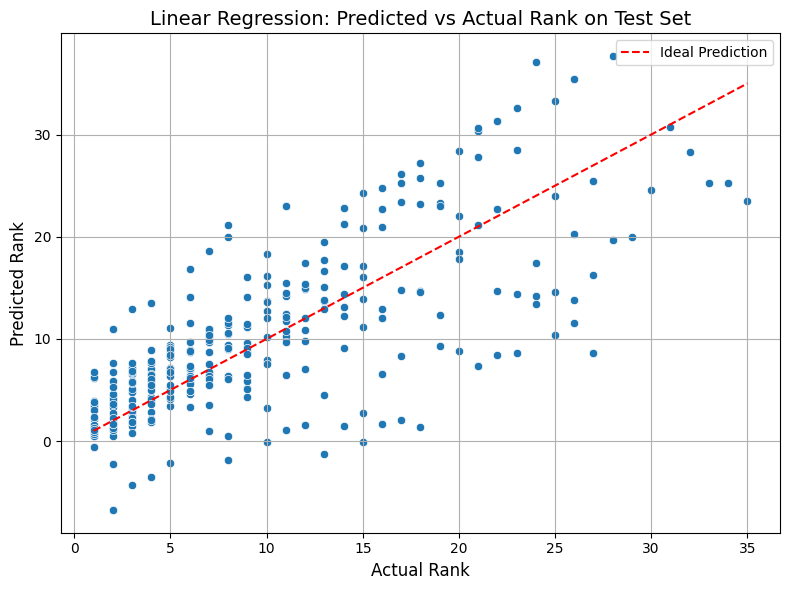

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df.iloc[test_idx]['Rank'],
    y=inverse_rank(X_test['User ID'].values, pipeline.predict(X_test), rank_min, rank_max)
)
plt.plot(
    [df.iloc[test_idx]['Rank'].min(), df.iloc[test_idx]['Rank'].max()],
    [df.iloc[test_idx]['Rank'].min(), df.iloc[test_idx]['Rank'].max()],
    color='red', linestyle='--', label='Ideal Prediction'
)
plt.xlabel('Actual Rank', fontsize=12)
plt.ylabel('Predicted Rank', fontsize=12)
plt.title('Linear Regression: Predicted vs Actual Rank on Test Set', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

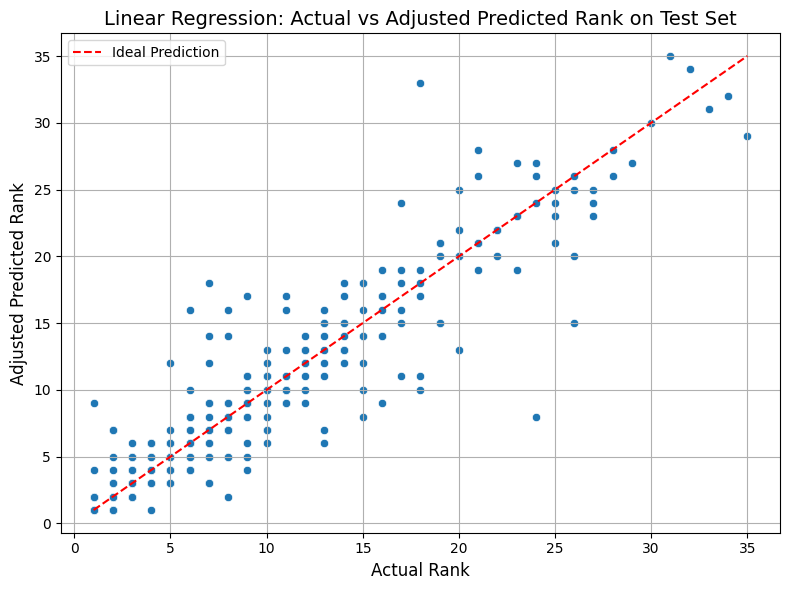

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=test_results_df['Actual_Rank'],
    y=test_results_df['Adjusted_Predicted_Rank']
)
plt.plot(
    [test_results_df['Actual_Rank'].min(), test_results_df['Actual_Rank'].max()],
    [test_results_df['Actual_Rank'].min(), test_results_df['Actual_Rank'].max()],
    color='red', linestyle='--', label='Ideal Prediction'
)
plt.xlabel('Actual Rank', fontsize=12)
plt.ylabel('Adjusted Predicted Rank', fontsize=12)
plt.title('Linear Regression: Actual vs Adjusted Predicted Rank on Test Set', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()